In [12]:
# Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import constants as const
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import evidential_deep_learning as edl
print(tf.__version__)

#import sciann as sn
#from scipy import stats
#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import statistics


2.8.1


In [2]:
# Import dataset using pandas

raw_dataset = pd.read_csv('../Dataset/Dataset_reduced.csv')
dataset = raw_dataset.copy()
print("Shape of dataset: "+str(dataset.shape))
dataset.tail()

Shape of dataset: (727292, 6)


,turbine,V,theta,W,T,P
727287,R80736,20.48,0.293564,1.801180,10817.3,2041980.0
727288,R80736,20.50,0.307352,1.799085,10837.3,2043120.0
727289,R80721,20.78,0.323933,1.799085,10850.1,2045870.0
727290,R80711,20.94,0.341386,1.799085,10853.8,2046570.0
727291,R80736,21.67,0.347670,1.798038,10871.8,2048260.0


In [3]:
# Clean dataset of NaN values
#dataset.isna().sum()
print(dataset.isna().sum())
dataset = dataset.dropna()

turbine    0
V          0
theta      0
W          0
T          0
P          0
dtype: int64


In [4]:
# One-hot encode categorical columns

dataset['turbine'] = dataset['turbine'].map({1:'R80711', 2:'R80721',3:'R80736', 4:'R80790'})
dataset = pd.get_dummies(dataset, columns=['turbine'], prefix='', prefix_sep='')
dataset.tail()

,V,theta,W,T,P
727287,20.48,0.293564,1.801180,10817.3,2041980.0
727288,20.50,0.307352,1.799085,10837.3,2043120.0
727289,20.78,0.323933,1.799085,10850.1,2045870.0
727290,20.94,0.341386,1.799085,10853.8,2046570.0
727291,21.67,0.347670,1.798038,10871.8,2048260.0


In [5]:
# Split the data into training and test sets

train_dataset = dataset.sample(frac=0.8, random_state=10)
test_dataset = dataset.drop(train_dataset.index)

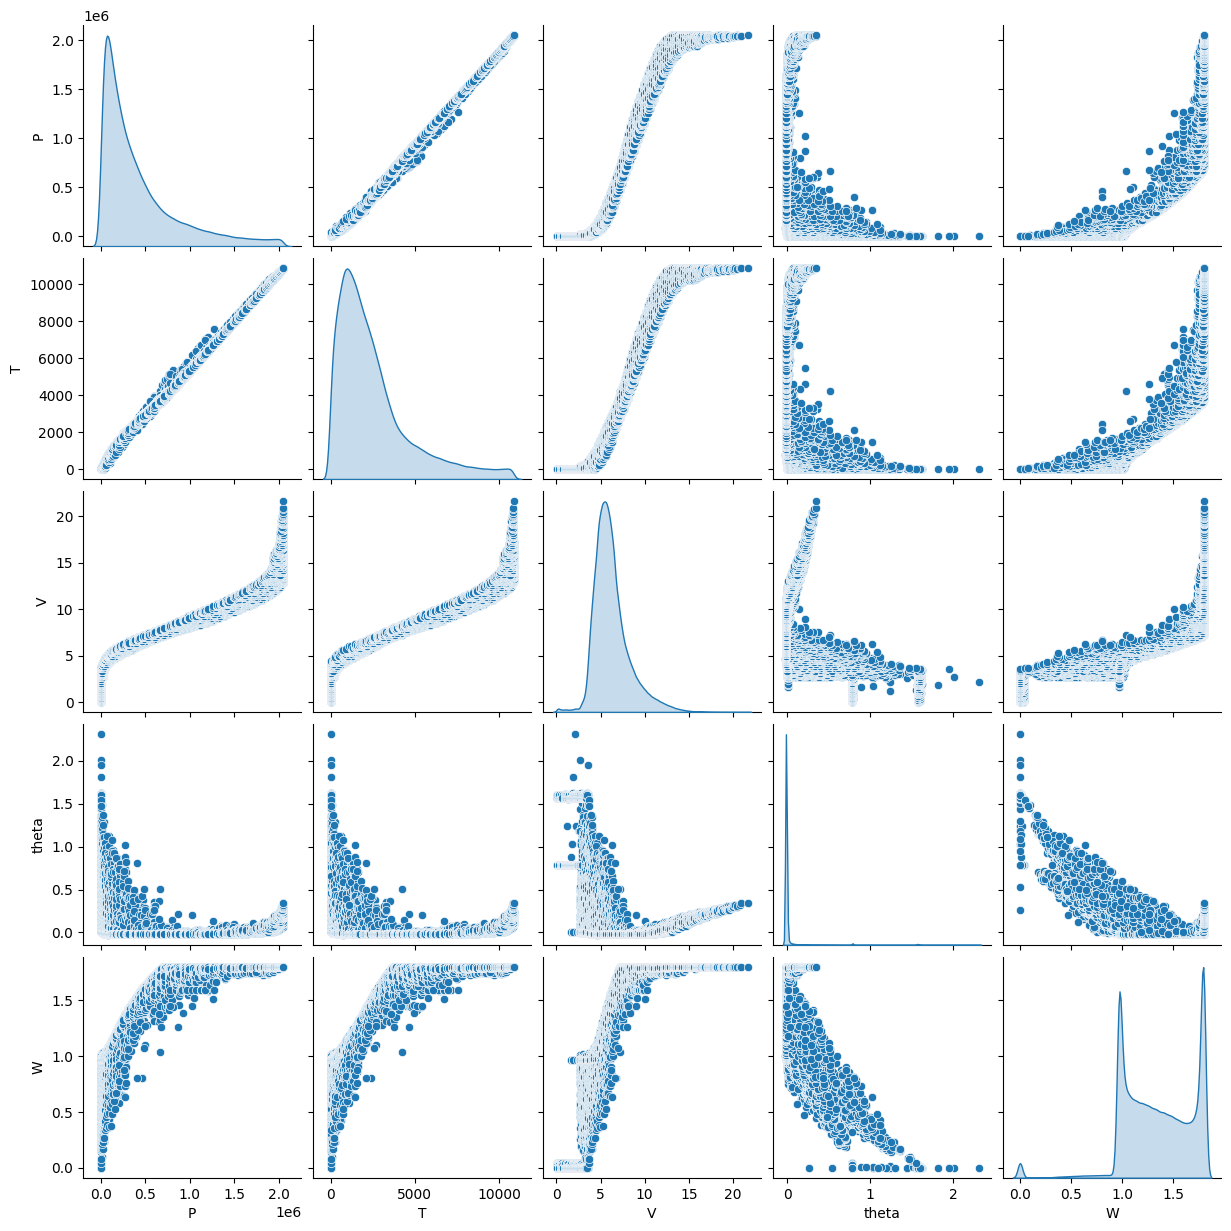

In [6]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

sns.pairplot(dataset[['P', 'T', 'V', 'theta', 'W']], diag_kind='kde')


In [6]:
# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
V,727292.0,6.281493,1.995660,0.230000,4.960000,5.870000,7.090000,2.167000e+01
theta,727292.0,0.002826,0.129452,-0.026704,-0.017453,-0.017279,-0.015708,2.312212e+00
W,727292.0,1.356542,0.329573,0.000000,1.089085,1.346696,1.660855,1.803274e+00
T,727292.0,2619.547843,2241.645819,0.000000,1043.010000,1963.324950,3376.169900,1.087570e+04
P,727292.0,439958.330594,442728.758322,0.000000,121400.000000,281620.000000,596549.992500,2.051870e+06


In [7]:
# Normalization

print(dataset.describe().transpose()[['mean', 'std']])

#tf.enable_eager_execution()
#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(np.array(train_features))

# adapt() method does not work, so we standarize each feature by hand

""" V = np.array(train_features['V'])
theta = np.array(train_features['theta'])
W = np.array(train_features['W'])
#Torque = np.array(train_labels['T'])
#Power = np.array(train_labels['P'])
Power = np.array(train_labels)

V_avrg = np.average(V[:])
V_std = np.std(V[:])
theta_avrg = np.average(theta[:])
theta_std = np.std(theta[:])
W_avrg = np.average(W[:])
W_std = np.std(W[:])
#T_avrg = np.average(Torque[:])
#T_std = np.std(Torque[:])
P_avrg = np.average(Power[:])
P_std = np.std(Power[:])

V[:] = ( V[:] - V_avrg ) / V_std
theta[:] = ( theta[:] - theta_avrg ) / theta_std
W[:] = ( W[:] - W_avrg ) / W_std
#Torque[:] = ( Torque[:] - T_avrg ) / T_std
Power[:] = ( Power[:] - P_avrg ) / P_std
 """

# Normalize pandas dataframe
#train_features=(train_features-train_features.mean())/train_features.std()
#test_features=(test_features-test_features.mean())/test_features.std()
#train_labels=(train_labels-train_labels.mean())/train_labels.std()
#test_features=(test_labels-test_labels.mean())/test_labels.std()

train_dataset_norm=(train_dataset-dataset.mean())/dataset.std()
test_dataset_norm=(test_dataset-dataset.mean())/dataset.std()

print()
print("Normalized dataset")
print(train_dataset_norm.describe().transpose()[['mean', 'std']])

                mean            std
V           6.281493       1.995660
theta       0.002826       0.129452
W           1.356542       0.329573
T        2619.547843    2241.645819
P      439958.330594  442728.758322

Normalized dataset
           mean       std
V     -0.000640  0.999263
theta  0.000388  1.002013
W     -0.000354  1.000316
T     -0.000550  0.999261
P     -0.000558  0.999263


In [8]:
# Split features from labels/targets

train_features = train_dataset_norm.copy()
test_features = test_dataset_norm.copy()

train_labels = train_features.pop('T')
test_labels = test_features.pop('T')

print(train_features.shape)
print(train_labels.shape)

(581834, 4)
(581834,)


In [9]:
# 1-input linear model 

""" x = np.array(train_features['V'])
inputs = tf.keras.Input(shape=(1,))

model = tf.keras.Sequential([
    inputs,
    layers.Dense(units=1)
])

model.summary() """


" x = np.array(train_features['V'])\ninputs = tf.keras.Input(shape=(1,))\n\nmodel = tf.keras.Sequential([\n    inputs,\n    layers.Dense(units=1)\n])\n\nmodel.summary() "

In [9]:
# Define the hypermodel to optimize hyperparameters

def model_builder(hp):
  
  input = tf.keras.Input(shape=(3,))
  model = keras.Sequential()

  # Tune the number of units in the Dense layers
  # Choose an optimal value between 8-128
  hp_units = hp.Int('units', min_value=8, max_value=128, step=2, sampling='log')
  
  # Tune the number of layers between 1-4
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1)
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1, sampling='linear')
  hp_layers = hp.Int('layers', min_value=1, max_value=4, step=2, sampling='log')

  # Tune activation function between relu, tanh and sigmoid
  #hp_activation = hp.Choice('activation', values=['relu','tanh','sigmoid'])
  hp_activation = hp.Choice('activation', values=['relu','tanh'])

  # Define architecture
  model.add(input)
  for i in range(hp_layers):
    #model.add(keras.layers.Dense(units=hp_units, activation='tanh'))
    model.add(keras.layers.Dense(units=hp_units, activation=hp_activation))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the batch size
  #hp_batch = hp.Int('batch', min_value=32, max_value=256, step=2, sampling='log')

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                #metrics=['accuracy'])
                loss='mean_absolute_error')   

  return model

In [10]:
# Instantiate the tuner and perform hypertuning

tuner = kt.Hyperband(model_builder,
                     #objective='val_accuracy',
                     objective='val_loss',
                     #max_epochs=10,
                     max_epochs=20,
                     factor=3,
                     #factor=2,
                     directory='./Hypertuning',
                     project_name='Torque')


INFO:tensorflow:Reloading Tuner from ./Hypertuning/Torque/tuner0.json


In [11]:
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

x = train_features[['V','theta','W']]
# search() method receives same arguments as fit() method, plus callbacks
# if batch_size is not specified, 32 is the default value
tuner.search(x, train_labels, epochs=20, validation_split=0.2, batch_size=128, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: {best_hps.get('layers')}
n_units: {best_hps.get('units')}
learning_rate: {best_hps.get('learning_rate')}
activation_function: {best_hps.get('activation')}
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: 2
n_units: 128
learning_rate: 0.001
activation_function: relu



In [13]:
# Define single model

n_layers = 2
n_units = 128
learning_rate = 0.001
activation_function = 'relu'

input = tf.keras.Input(shape=(3,))
model = keras.Sequential()
model.add(input)

for i in range(n_layers):    
    model.add(keras.layers.Dense(units=n_units, activation=activation_function))
#model.add(keras.layers.Dense(1))
model.add(edl.layers.DenseNormalGamma(1))

model.summary() 

#model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
#              loss='mean_absolute_error') 

# Custom loss function to handle the custom regularizer coefficient
def EvidentialRegressionLoss(true, pred):
    return edl.losses.EvidentialRegression(true, pred, coeff=1e-2)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=EvidentialRegressionLoss)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_normal_gamma (DenseNo  (None, 4)                516       
 rmalGamma)                                                      
                                                                 
Total params: 17,540
Trainable params: 17,540
Non-trainable params: 0
_________________________________________________________________


2023-05-07 17:16:09.423162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-07 17:16:09.478902: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-05-07 17:16:09.478923: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-07 17:16:09.479835: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [14]:
# Train the model with optimal hyperparameters

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-8)

# Build the model with the optimal hyperparameters and train it on the data for 500 epochs
#model = tuner.hypermodel.build(best_hps)
history = model.fit(x, train_labels, epochs=200, batch_size=128, validation_split=0.2, callbacks=[reduce_lr])

Epoch 1/200
3637/3637 [==============================] - 4s 1ms/step - loss: -1.7542 - val_loss: -1.8512 - lr: 0.0010
Epoch 2/200
3637/3637 [==============================] - 4s 979us/step - loss: -1.8688 - val_loss: -1.9350 - lr: 0.0010
Epoch 3/200
3637/3637 [==============================] - 4s 987us/step - loss: -1.8848 - val_loss: -1.8613 - lr: 0.0010
Epoch 4/200
3637/3637 [==============================] - 4s 973us/step - loss: -1.8909 - val_loss: -1.9247 - lr: 0.0010
Epoch 5/200
3637/3637 [==============================] - 4s 983us/step - loss: -1.9014 - val_loss: -1.9254 - lr: 0.0010
Epoch 6/200
3637/3637 [==============================] - 4s 993us/step - loss: -1.9071 - val_loss: -1.8932 - lr: 0.0010
Epoch 7/200
3637/3637 [==============================] - 4s 984us/step - loss: -1.9170 - val_loss: -1.9329 - lr: 0.0010
Epoch 8/200
3637/3637 [==============================] - 4s 992us/step - loss: -1.9204 - val_loss: -1.9532 - lr: 0.0010
Epoch 9/200
3637/3637 [===================

Best epoch: 193


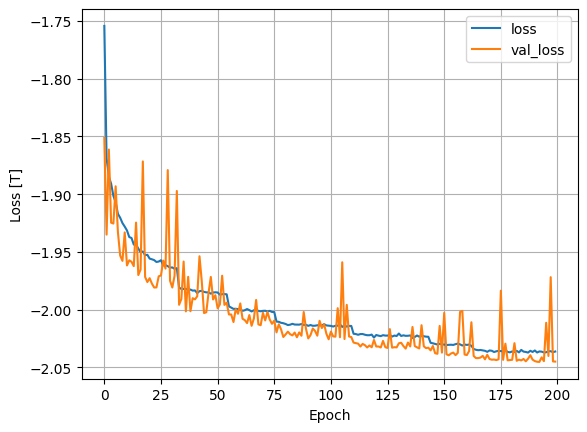

In [15]:
# Plot the loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss [T]')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
""" # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x, train_labels, epochs=best_epoch, batch_size=128, validation_split=0.2, callbacks=[reduce_lr]) """

In [14]:
# save model weights 
#model.save_weights('../Models/Torque_model_weights.hdf5')

# load model weights
#model.load_weights('../Models/Torque_model_weights.hdf5')

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
#model.save('../Models/Torque_model.h5')

# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
#new_model.summary()

In [2]:
# load model 

#model = tf.keras.models.load_model('../Models/Torque_model.h5')
#model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50,177
Trainable params: 50,177
Non-trainable params: 0
_________________________________________________________________


2023-03-14 13:48:50.049332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 13:48:50.100579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-14 13:48:50.100594: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-14 13:48:50.101381: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [16]:
def plot_PredvsTrue(y_true, y_pred, n_stds=2):

    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)[:, 0]  # for visualization
    #y_true = y_true[:,0]

    plt.figure(figsize=(5, 5), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="True")
    #plt.plot(y_true, y_true, 'r--', zorder=2, label="True")
    #plt.plot(y_true, mu, color='#007cab', zorder=3, label="Pred")
    plt.scatter(y_true,mu,color="blue",label="Pred",s=4)
    for k in np.linspace(0, n_stds, n_stds):
        plt.fill_between(
            y_true, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    #plt.gca().set_xlim(-200, 200)
    #plt.gca().set_ylim(-200, 200)
    #plt.gca().set_xlim(0.8*p1, 1.1*p2)
    #plt.gca().set_ylim(0.9*p1, 1.1*p2)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

2023-05-07 17:30:14.712501: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 74474496 exceeds 10% of free system memory.
2023-05-07 17:30:14.723872: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 74474496 exceeds 10% of free system memory.
2023-05-07 17:30:14.753762: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 74474496 exceeds 10% of free system memory.
2023-05-07 17:30:14.769429: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 74474496 exceeds 10% of free system memory.
2023-05-07 17:30:14.782881: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 74474496 exceeds 10% of free system memory.


(145458, 3)
(145458, 4)
(145458,)


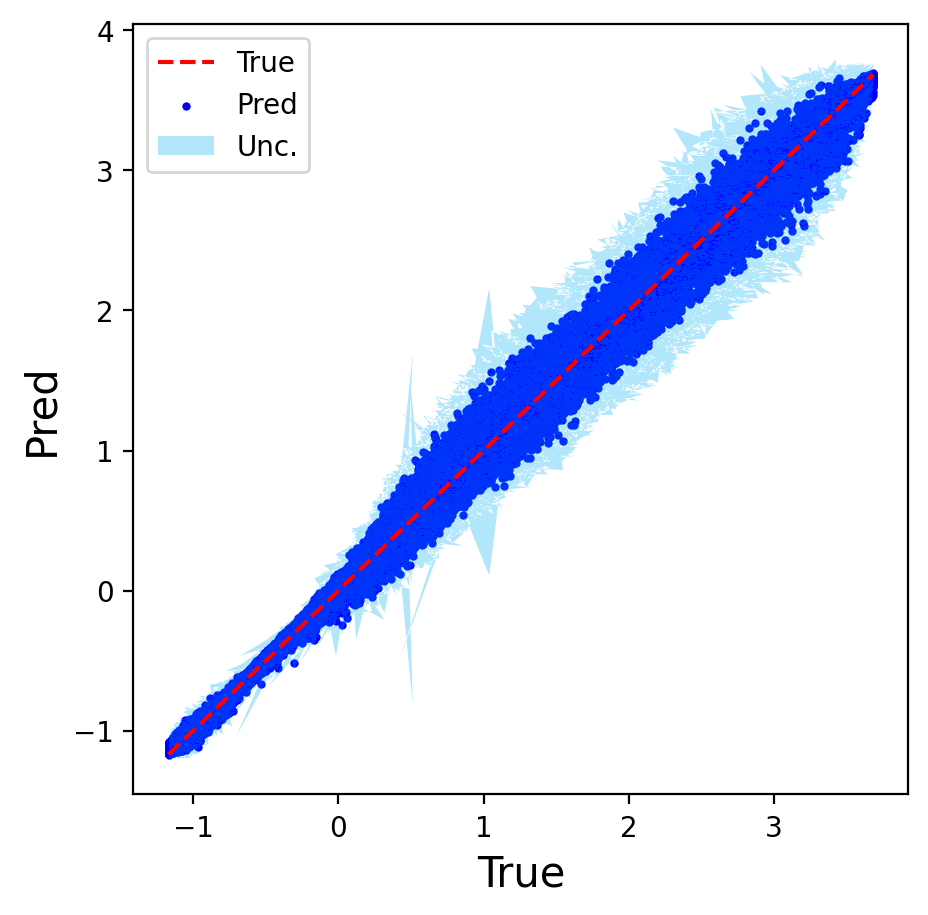

Test MAE: 0.03800346744573932


' test_pred = model.predict(test_features[[\'V\',\'theta\',\'W\']]).flatten()\n\na = plt.axes(aspect=\'equal\')\np1 = max(max(test_pred), max(test_labels))\np2 = min(min(test_pred), min(test_labels))\nplt.plot([p1, p2], [p1, p2], \'r--\')\nplt.scatter(test_labels, test_pred)\nplt.xlabel(\'True Values [T]\')\nplt.ylabel(\'Predictions [T]\')\nplt.show()\n#lims = [0, 50]\n#plt.xlim(lims)\n#plt.ylim(lims)\n#_ = plt.plot(lims, lims)\n\ntest_result = model.evaluate(test_features[[\'V\',\'theta\',\'W\']], test_labels, verbose=0)\nprint("Test MAE: "+str(test_result)) '

In [17]:
# Evaluation of the model on Torque data

# Pred vs True values

x_test = np.array(test_features[['V','theta','W']])
y_pred = model(x_test)
y_true = np.array(test_labels)

print(x_test.shape)
print(y_pred.shape)
print(y_true.shape)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred[:,0])
print("Test MAE: "+str(test_mae))

In [18]:
def plot_PredvsTrue_error(y_true, y_pred, error, n_stds=2):

    #mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    #mu = mu[:, 0]
    #var = np.sqrt(beta / (v * (alpha - 1)))
    mu = y_pred
    var = error
    #var = np.minimum(var, 1e3)[:, 0]  # for visualization
    #y_true = y_true[:,0]

    plt.figure(figsize=(5, 5), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="True")
    #plt.plot(y_true, y_true, 'r--', zorder=2, label="True")
    #plt.plot(y_true, mu, color='#007cab', zorder=3, label="Pred")
    plt.scatter(y_true,mu,color="blue",label="Pred",s=4)
    for k in np.linspace(0, n_stds, n_stds):
        plt.fill_between(
            y_true, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    #plt.gca().set_xlim(-200, 200)
    #plt.gca().set_ylim(-200, 200)
    #plt.gca().set_xlim(0.8*p1, 1.1*p2)
    #plt.gca().set_ylim(0.9*p1, 1.1*p2)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

['V' 'theta' 'W' 'T' 'P']


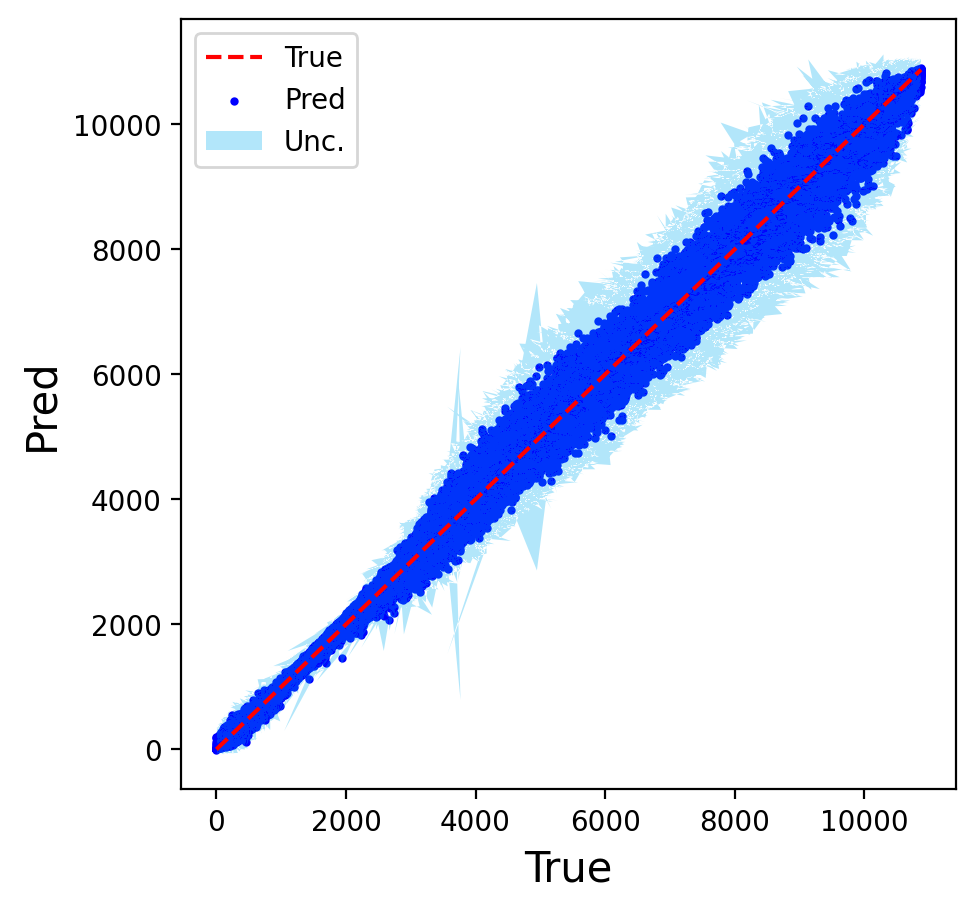


Test MAE: 85.19025498231943
Test RMSE: 145.9130012459526
Test MAPE: 62.78156182233371 %
Test R2: 0.9957878957073819


' y_pred = model.predict(test_features[[\'V\',\'theta\',\'W\']]).flatten()\ny_true = test_labels\n\nx_mean = np.nanmean( dataset, axis=0)\nx_std = np.nanstd( dataset, axis=0 )\ncolumn_name = dataset.columns.values\nprint(column_name)\nTorque_column = 3 \n\ny_pred = y_pred * x_std[3] + x_mean[3]\ny_true = y_true * x_std[3] + x_mean[3]\n\na = plt.axes(aspect=\'equal\')\np1 = max(max(y_pred), max(y_true))\np2 = min(min(y_pred), min(y_true))\nplt.plot([p1, p2], [p1, p2], \'r--\')\nplt.scatter(y_true, y_pred)\nplt.xlabel(\'True Values [T]\')\nplt.ylabel(\'Predictions [T]\')\nplt.show()\n#lims = [0, 50]\n#plt.xlim(lims)\n#plt.ylim(lims)\n#_ = plt.plot(lims, lims)\n\ny_pred_nonzero = y_pred[abs(y_true)>1e-1]\ny_true_nonzero = y_true[abs(y_true)>1e-1]\n\ntest_mae = mean_absolute_error(y_true,y_pred)\ntest_rmse = mean_squared_error(y_true,y_pred,squared=False)\n#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100\ntest_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzer

In [21]:
# Evaluate T on original units

# Pred vs True values

x_test = np.array(test_features[['V','theta','W']])
y_pred = model(x_test)
y_true = np.array(test_labels)

mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
mu = mu[:, 0]
error_pred = np.sqrt(beta / (v * (alpha - 1)))

y_pred = y_pred[:,0]
error_pred = error_pred[:,0]

x_mean = np.nanmean( dataset, axis=0)
x_std = np.nanstd( dataset, axis=0 )
column_name = dataset.columns.values
print(column_name)
Torque_column = 3 

y_pred = y_pred * x_std[3] + x_mean[3]
y_true = y_true * x_std[3] + x_mean[3]
error_pred = error_pred * x_std[3] # propagation of error

#print(x_test.shape)
#print(y_pred.shape)
#print(y_true.shape)

#plot_PredvsTrue(y_true, y_pred)
plot_PredvsTrue_error(y_true, y_pred, error_pred)

y_pred_nonzero = y_pred[abs(y_true)>0]
y_true_nonzero = y_true[abs(y_true)>0]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

""" y_pred = model.predict(test_features[['V','theta','W']]).flatten()
y_true = test_labels

x_mean = np.nanmean( dataset, axis=0)
x_std = np.nanstd( dataset, axis=0 )
column_name = dataset.columns.values
print(column_name)
Torque_column = 3 

y_pred = y_pred * x_std[3] + x_mean[3]
y_true = y_true * x_std[3] + x_mean[3]

a = plt.axes(aspect='equal')
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(y_true, y_pred)
plt.xlabel('True Values [T]')
plt.ylabel('Predictions [T]')
plt.show()
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

y_pred_nonzero = y_pred[abs(y_true)>1e-1]
y_true_nonzero = y_true[abs(y_true)>1e-1]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2)) """

['V' 'theta' 'W' 'T' 'P']


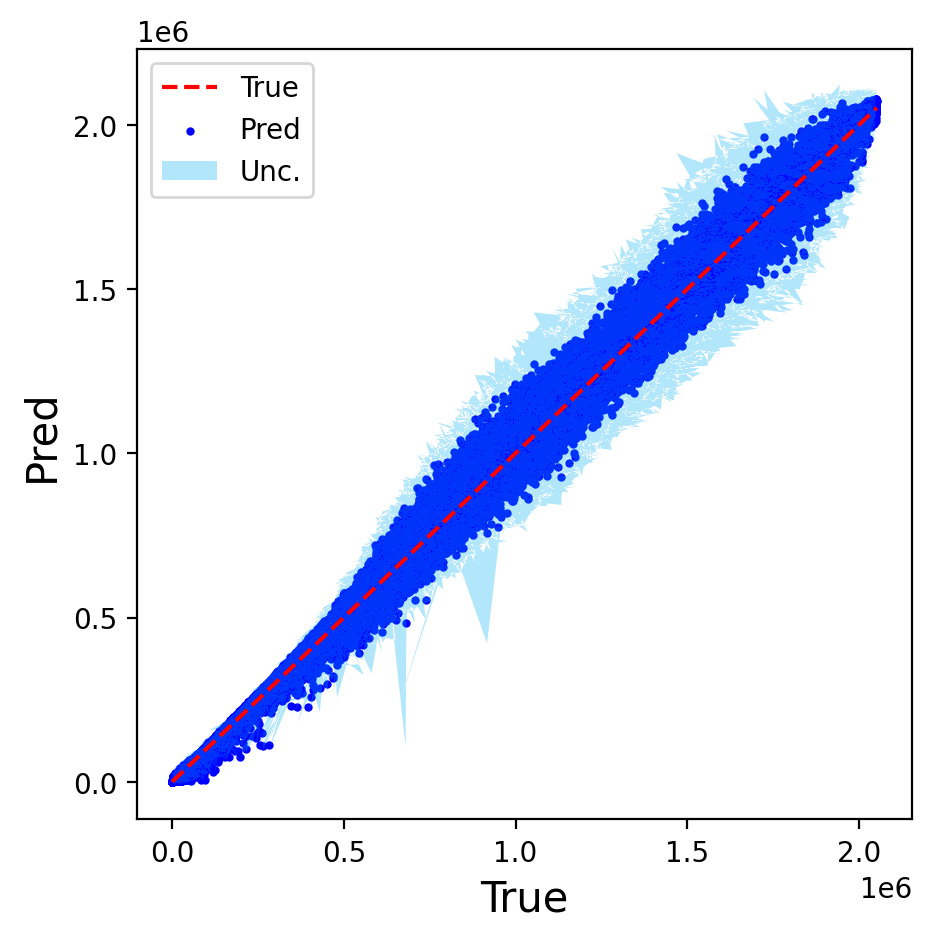


Test MAE: 15692.092305304228
Test RMSE: 28236.421526599537
Test MAPE: 3.9058780904353894 %
Test R2: 0.9959561404439939


' T_pred = model.predict(test_features[[\'V\',\'theta\',\'W\']]).flatten()\nT_true = test_labels\nT_pred = T_pred * x_std[3] + x_mean[3]\nT_true = T_true * x_std[3] + x_mean[3]\n\nW_true = test_dataset.loc[:,\'W\']\nW_true = W_true.to_numpy()\nP_true = test_dataset.loc[:,\'P\']\nP_true = P_true.to_numpy()\nP_pred = P_fromT(T_pred,W_true)\n\ny_true = P_true\ny_pred = P_pred\n\n# Plot\na = plt.axes(aspect=\'equal\')\np1 = max(max(y_pred), max(y_true))\np2 = min(min(y_pred), min(y_true))\nplt.plot([p1, p2], [p1, p2], \'r--\')\nplt.scatter(y_true, y_pred)\nplt.xlabel(\'True Values [P]\')\nplt.ylabel(\'Predictions [P]\')\nplt.title(\'P from T\')\nplt.show()\n#lims = [0, 50]\n#plt.xlim(lims)\n#plt.ylim(lims)\n#_ = plt.plot(lims, lims)\n\n# Metrics\np_cutoff = 25000\ny_pred_nonzero = y_pred[abs(y_true)>p_cutoff]\ny_true_nonzero = y_true[abs(y_true)>p_cutoff]\n\ntest_mae = mean_absolute_error(y_true,y_pred)\ntest_rmse = mean_squared_error(y_true,y_pred,squared=False)\n#test_mape = mean_absolut

In [22]:
# Evaluate P from T

def P_fromT(T, W):
    Pturbina = const.gear * T * W
    return Pturbina

# Pred vs True values

x_test = np.array(test_features[['V','theta','W']])
T_pred = model(x_test)
T_true = np.array(test_labels)

mu, v, alpha, beta = tf.split(T_pred, 4, axis=-1)
mu = mu[:, 0]
error_pred = np.sqrt(beta / (v * (alpha - 1)))

T_pred = T_pred[:,0]
error_pred = error_pred[:,0]

x_mean = np.nanmean( dataset, axis=0)
x_std = np.nanstd( dataset, axis=0 )
column_name = dataset.columns.values
print(column_name)
Torque_column = 3 

T_pred = T_pred * x_std[3] + x_mean[3]
T_true = T_true * x_std[3] + x_mean[3]
error_pred = error_pred * x_std[3] # propagation of error

W_true = test_dataset.loc[:,'W']
W_true = W_true.to_numpy()
P_true = test_dataset.loc[:,'P']
P_true = P_true.to_numpy()
P_pred = P_fromT(T_pred,W_true)

y_true = P_true
y_pred = P_pred

error_pred[:] = error_pred[:] * const.gear * W_true  # propagate error from T to P

y_true = P_true
y_pred = P_pred

#plot_PredvsTrue(y_true, y_pred)
plot_PredvsTrue_error(y_true, y_pred, error_pred)

# Metrics
p_cutoff = 25000
y_pred_nonzero = y_pred[abs(y_true)>p_cutoff]
y_true_nonzero = y_true[abs(y_true)>p_cutoff]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

Mean Absolute Error: 15692.092
Mean Absolute Uncertainty: 17314.674


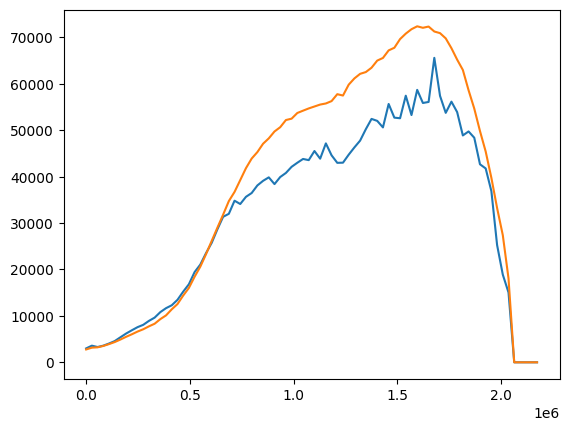

In [23]:
# Mean uncertainty. True error vs Power. Uncertainty vs Power

#print(P_pred.shape)
#print(error_pred.shape)
error_true = np.abs(P_pred-P_true)
print('Mean Absolute Error: '+str(np.mean(error_true)))
print('Mean Absolute Uncertainty: '+str(np.mean(error_pred)))

nbins = 80
Pmax = 2200*1e3
Pmin = 0
dP = (Pmax-Pmin)/nbins
error_histo = np.zeros(nbins)
uncertainty_histo = np.zeros(nbins)
n_histo = np.zeros(nbins)
for i in range(len(P_pred)):
    #j = int(P_pred[i]/dP)
    j = int(P_true[i]/dP)
    error_histo[j] = error_histo[j] + error_true[i]
    uncertainty_histo[j] = uncertainty_histo[j] + error_pred[i]
    n_histo[j] = n_histo[j]+1

for j in range(nbins):
    if(n_histo[j]>0):
        error_histo[j] = error_histo[j]/n_histo[j]    
        uncertainty_histo[j] = uncertainty_histo[j]/n_histo[j]    
P_array = np.arange(Pmin+0.5,Pmax-0.5,dP)

# True error vs Power
plt.plot(P_array,error_histo)

# Uncertainty vs Power
plt.plot(P_array,uncertainty_histo)
